# Importo tutte le librerie necessarie

In [1]:
import clip
import random
import math
from PIL import Image
import pickle
import numpy as np
from pathlib import Path
from sklearn.svm import SVC
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import subprocess
from shutil import copyfile
import torch.nn.functional as F
try:
    subprocess.run(["nvidia-smi"], check=True)
except subprocess.CalledProcessError as e:
    print("Errore nvidia-smi:", e)

from IPython.display import display, HTML
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
from scripts.pre_processing import metadata_list
import torch
import torch.nn as nn       # Per nn.TripletMarginLoss e per la definizione di TripletNet
import torch.optim as optim # Per optim.Adam
from torch.utils.data import DataLoader
import os

Dataset 0:
            filename                               image_path  target category
0      img009828.jpg   afhq/afhq/afhq/train/dog/img009828.jpg       0      dog
1      img025087.jpg     afhq/afhq_v2/train/dog/img025087.jpg       0      dog
2      img021571.jpg     afhq/afhq_v2/train/cat/img021571.jpg       0      cat
3      img028797.jpg    afhq/afhq_v2/train/wild/img028797.jpg       0     wild
4      img028196.jpg    afhq/afhq_v2/train/wild/img028196.jpg       0     wild
...              ...                                      ...     ...      ...
31928  img022404.jpg     afhq/afhq_v2/train/cat/img022404.jpg       0      cat
31929  img007440.jpg   afhq/afhq/afhq/train/dog/img007440.jpg       0      dog
31930  img010198.jpg  afhq/afhq/afhq/train/wild/img010198.jpg       0     wild
31931  img022083.jpg     afhq/afhq_v2/train/cat/img022083.jpg       0      cat
31932  img014138.jpg  afhq/afhq/afhq/train/wild/img014138.jpg       0     wild

[31933 rows x 4 columns]


Dataset 1:
  

# Definizione della funzione Early_stopping che permette di ottimizzare i parametri per dare il pieno controllo su quando e come l'addestramento si interrompe
Questa funzione fa in modo che l'addestramento si blocca prematuramente quando il modello smette di migliorare. Inoltre:
1) Evita overfitting interrompendo quando la loss non migliora per patience epoche
2) Salva checkpoint con backup ridondante
3) Supporta diverse metriche di monitoraggio (loss/accuracy)
4) Gestisce casi limite con sistema di recovery

In [2]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', monitor='val_loss', mode='min'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.backup_path = "backup_checkpoint.pt"  # Backup integrato
        self.monitor = monitor
        self.mode = mode

        if self.mode == 'min':
            self.best_score = np.Inf
        else:
            self.best_score = -np.Inf

    def __call__(self, current_metric_value, model=None):
        if self.mode == 'min':
            if current_metric_value < self.best_score - self.delta:
                self.save_checkpoint(current_metric_value, model)
                self.best_score = current_metric_value
                self.counter = 0
            else:
                self.counter += 1
        else:
            if current_metric_value > self.best_score + self.delta:
                self.save_checkpoint(current_metric_value, model)
                self.best_score = current_metric_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, val_metric_value, model=None):
        try:
            # Crea backup se esiste già un checkpoint
            if Path(self.path).exists():
                copyfile(self.path, self.backup_path)

            # Salva nuovo checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_metric': val_metric_value
            }, self.path)

            if self.verbose:
                print(f"Checkpoint salvato in {self.path}")
        except Exception as e:
            print(f"[CRITICO] Errore salvataggio: {str(e)}")
            print(f"Tentativo di ripristino backup {self.backup_path}")
            if Path(self.backup_path).exists():
                copyfile(self.backup_path, self.path)

# Controlli iniziali sulla GPU da eseguire prima di qualsiasi operazione

In [3]:
display(HTML("<style>.output_wrapper .output { max-height: 10000px; }</style>"))

# Imposta il limite di dati subito dopo
%config ServerApp.iopub_data_rate_limit=1000000000  # 1GB/sec
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config Completer.use_jedi = False

# PRIMA di chiamare generate_and_save_embeddings, pulisco la memoria:
gc.collect()
torch.cuda.empty_cache()

# Eseguo la generazione degli embedding con batch size ridotto:
print("\n[INFO] Inizio generazione embedding con controllo memoria...")
!nvidia-smi  # Check iniziale GPU

# Dopo l'operazione, pulisci di nuovo e verifica
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi  # Check finale GPU

# Funzione di utilità per monitoraggio GPU
def print_gpu_utilization():
    if torch.cuda.is_available():
        print(f"[GPU] Memoria allocata: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        print(f"[GPU] Memoria riservata: {torch.cuda.memory_reserved()/1024**2:.2f} MB")
    else:
        print("[GPU] CUDA non disponibile")


os.system("nvidia-smi # ...")  # Cerca comandi con caratteri speciali


[INFO] Inizio generazione embedding con controllo memoria...
ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.

ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.



255

# Utilizzo cuda al posto della CPU per velocizzare il processo

In [4]:
# === Configurazione dispositivo ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Dispositivo in uso:", device)
if device == "cuda":
    print("CUDA disponibile:", torch.cuda.is_available())
    print("Nome GPU:", torch.cuda.get_device_name(0))
    print_gpu_utilization()

[INFO] Dispositivo in uso: cuda
CUDA disponibile: True
Nome GPU: NVIDIA GeForce GTX 1050 Ti
[GPU] Memoria allocata: 0.00 MB
[GPU] Memoria riservata: 0.00 MB


# Importo il dataset cycle_gan poichè contiene nella colonna target sia 0 che 1
La scelta di questo dataset è dovuta dal fatto che il nostro obiettivo è quello di indicare se l'immagine in input è reale o fake. Di conseguenza CLIP funziona solo se abbiamo un dataset con immagini sia reali che fake. Questo dataset rispetta tale condizione.

In [5]:
def get_datasets(metadata_list, index):
    if len(metadata_list) > index:
        return metadata_list[index]
    raise IndexError("L'indice specificato non è valido")

# Esempio di utilizzo corretto
try:
    dataset_cycle_gan = get_datasets(metadata_list, 5)  # Solo Cycle-GAN
    print("[INFO] Dataset Cycle-GAN:")
    print(dataset_cycle_gan)
except IndexError as e:
    print(f"[ERRORE] {e}")

[INFO] Dataset Cycle-GAN:
            filename                    image_path  target     category
0      img000851.jpg  st/horse2zebra/img000851.jpg       0  horse2zebra
1      img004163.jpg  st/horse2zebra/img004163.jpg       0  horse2zebra
2      img003305.jpg  st/horse2zebra/img003305.jpg       0  horse2zebra
3      img001548.jpg  st/horse2zebra/img001548.jpg       1  horse2zebra
4      img004940.jpg  st/horse2zebra/img004940.jpg       1  horse2zebra
...              ...                           ...     ...          ...
15205  img016350.jpg  st/photo2monet/img016350.jpg       0  photo2monet
15206  img011734.jpg  st/photo2monet/img011734.jpg       0  photo2monet
15207  img015011.jpg  st/photo2monet/img015011.jpg       0  photo2monet
15208  img014558.jpg  st/photo2monet/img014558.jpg       1  photo2monet
15209  img015042.jpg  st/photo2monet/img015042.jpg       0  photo2monet

[15210 rows x 4 columns]


# Caricamento del modello CLIP e creazione di un metodo che permette di estrarre singolarmente sia le singole immagini convertendole in vettori di embedding di dimensione 512. Questo passaggio è fondamentale poichè il modello CLIP non è in grado di lavorare direttamente sulle immagini.
Nel preciso momento in cui viene estratta l'immagine, quando viene passata al modello CLIP, l'immagine viene processata  e dal momento che utilizziamo il modello con transformer Vit-B/32, l'immagine viene ridimensionata a 224x224. Successivamente viene convertita in vettore di embedding ma prima di effettuare tale operazione, verifico se il ridimensionamento è avvenuto correttamente, facendomi stampare un'immagine presa dal dataset.

In [6]:
# === Percorsi dei dataset ===
BASE_DATASET_PATH = Path("..") / "dataset" / "cycle_gan"
BASE_DATASET_PATH = BASE_DATASET_PATH.resolve()
print(f"[INFO] Percorso base del dataset: {BASE_DATASET_PATH}")

# === Caricamento modello CLIP ===
model, preprocess = clip.load("ViT-B/32", device=device)

# Funzione di denormalizzazione per CLIP
def denormalize_clip_image(tensor):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).reshape(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).reshape(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def generate_and_save_embeddings(image_paths, clip_model, batch_size=128, device="cuda"):
    BASE_DATASET_PATH = Path("../dataset/cycle_gan")

    # 1. Costruzione del dizionario path-target
    path_to_target = {
        str((BASE_DATASET_PATH / row['image_path']).resolve()).lower().replace("\\", "/"): row['target']
        for _, row in dataset_cycle_gan.iterrows()
    }

    # 2. Inizializzazione componenti CLIP
    clip_preprocess = clip.load("ViT-B/32", device=device)[1]
    embeddings_list = []
    labels_list = []

    # 3. Loop principale corretto
    for img_path in tqdm(image_paths, desc="Generazione embedding"):
        try:
            # Normalizzazione percorso
            abs_path = Path(img_path).resolve()
            abs_normalized = str(abs_path).lower().replace("\\", "/")

            # Ricerca target
            target = path_to_target.get(abs_normalized)

            if target is None:
                continue  # Salta immagini non mappate

            # Processamento immagine
            with Image.open(img_path) as img:
                img.verify()

            image = Image.open(img_path).convert("RGB")
            image_tensor = clip_preprocess(image).unsqueeze(0).to(device)

            # Generazione embedding
            with torch.no_grad():
                embedding = clip_model.encode_image(image_tensor).cpu().numpy()[0]  # Correzione chiave

            embeddings_list.append(embedding)
            labels_list.append(target)

        except Exception as e:
            print(f"Errore su {img_path}: {str(e)}")
            continue

    # 4. Controllo finale
    if len(embeddings_list) == 0:
        raise ValueError("Nessun embedding generato. Verifica la mappatura path-target e le immagini")

    return np.array(embeddings_list), np.array(labels_list)

[INFO] Percorso base del dataset: D:\Progetti\DeepFake\DeepFake\dataset\cycle_gan


# Verifica se i vettori di embedding sono stati generati correttamente

In [7]:
# Funzione: verifica embedding e preprocess immagini
def verifica_embedding_clip(model, preprocess, embeddings_dict, dataset_df, index=0):
    if index >= len(dataset_df):
        print("[ERRORE] Indice non valido.")
        return

    row = dataset_df.iloc[index]
    filename = row['filename']

    if filename not in embeddings_dict:
        print(f"[ERRORE] Embedding non trovato per {filename}")
        return

    embedding_data = embeddings_dict[filename]
    img_path = Path(embedding_data['image_path'])
    label = embedding_data['target']
    embedding = embedding_data['embedding']

    print(f"[INFO] Immagine: {filename}")
    print(f"• Etichetta: {label}")
    print(f"• Dimensione embedding: {embedding.shape}")
    print(f"• Primi valori embedding: {embedding[:5]}...")

    try:
        # Carica immagine
        original_img = Image.open(img_path).convert("RGB")
        print(f"[DEBUG] Dimensioni originali: {original_img.size}")

        # Preprocess con CLIP
        processed_tensor = preprocess(original_img).to(device)
        h, w = processed_tensor.shape[-2:]

        # Verifica dimensioni
        if (h, w) != (224, 224):
            print(f"[ATTENZIONE] Dimensioni dopo preprocess non corrette: {h}x{w} (attese: 224x224)")
        else:
            print("[OK] Dimensioni dopo preprocess: 224x224")

        # Denormalizza
        denorm_img = denormalize_clip_image(processed_tensor).permute(1, 2, 0).cpu().numpy()
        denorm_img = np.clip(denorm_img, 0, 1)

        # Visualizza immagini
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_img)
        axes[0].set_title("Immagine originale")
        axes[0].axis("off")

        axes[1].imshow(denorm_img)
        axes[1].set_title("Dopo preprocessing (Denormalizzata)")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[ERRORE] Visualizzazione fallita: {e}")

# Generazione delle triplette per i vettori di embedding
Per garantire una suddivisione più precisa tra immagine reale e immagine fake, utiizziamo la funzione triplet loss che consiste nell'identificazione delle triplette per anchor, positive e negative. Lo scopo principale è quello di minimizzare la distanza tra anchor e positive e massimizzare la distanza tra anchor e negative. In anchor sono presenti le immagini reali (target=0), in positive le immagini simili a quelle reali mentre in negative sono presenti le immagini fake (target=1).

In [8]:
def generate_triplets_fixed_batch(embeddings, labels, batch_size=128, n_triplets=10000):
    n = len(embeddings)
    if n < 2:
        raise ValueError("Il dataset deve contenere almeno 2 campioni")

    # Precalcolo struttura per accesso efficiente
    class_indices = {}
    for idx, label in enumerate(labels):
        class_indices.setdefault(label, []).append(idx)

    # Controllo classi con un solo campione
    valid_classes = [label for label, indices in class_indices.items() if len(indices) >= 2]
    if not valid_classes:
        raise ValueError("Nessuna classe valida con almeno 2 campioni")

    # Preparazione output
    triplet_batches = []
    current_batch = []
    count = 0

    while count < n_triplets:
        # 1. Seleziona classe ancora valida (almeno 2 campioni)
        class_label = valid_classes[np.random.randint(0, len(valid_classes))]
        class_indices_list = class_indices[class_label]

        # 2. Seleziona ancora e positivo (diversi tra loro)
        anchor_idx, positive_idx = np.random.choice(class_indices_list, 2, replace=False)

        # 3. Seleziona negativo (campionamento efficiente)
        while True:
            negative_idx = np.random.randint(0, n)
            if labels[negative_idx] != class_label:
                break

        # 4. Costruisci tripletta
        triplet = (
            embeddings[anchor_idx],
            embeddings[positive_idx],
            embeddings[negative_idx]
        )
        current_batch.append(triplet)

        # 5. Gestione batch completo
        if len(current_batch) == batch_size:
            anchors, positives, negatives = zip(*current_batch)
            triplet_batches.append((
                np.stack(anchors),
                np.stack(positives),
                np.stack(negatives)
            ))
            current_batch = []

        count += 1

    # Aggiungi eventuale batch finale incompleto
    if current_batch:
        anchors, positives, negatives = zip(*current_batch)
        triplet_batches.append((
            np.stack(anchors),
            np.stack(positives),
            np.stack(negatives)
        ))

    return triplet_batches

# Definisco una funzione chiamata Triplet Model che è una rete neurale che impara a proiettare gli embedding in uno spazio dove le distanze riflettono la similarità.

In [9]:
class TripletModel(nn.Module):
    def __init__(self, input_dim=512, embedding_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )

    def forward(self, x):
        return self.fc(x)

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=1e-4):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = TripletLoss(margin=0.2, distance="euclidean")  # Usa la nostra loss

        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0.0

            for batch in train_loader:
                anchor, positive, negative = batch
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass
                anchor_emb = self(anchor)
                positive_emb = self(positive)
                negative_emb = self(negative)

                # Calcola la loss
                loss = criterion(anchor_emb, positive_emb, negative_emb)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Loss media per epoca
            avg_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

# Definisco la funzione Triplet Loss che utilizza le triplette per regolare i pesi della rete, minimizzando la distanza anchor-positive e massimizzando anchor-negative.

In [10]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2, distance="euclidean"):
        super().__init__()
        self.margin = margin
        self.distance = distance

    def _pairwise_distance(self, x1, x2):
        if self.distance == "euclidean":
            return F.pairwise_distance(x1, x2, p=2)
        elif self.distance == "cosine":
            return 1 - F.cosine_similarity(x1, x2)
        else:
            raise ValueError("Distanza non supportata")

    def forward(self, anchor, positive, negative):
        d_pos = self._pairwise_distance(anchor, positive)
        d_neg = self._pairwise_distance(anchor, negative)
        losses = F.relu(d_pos - d_neg + self.margin)
        return losses.mean()

# Grafico che mostra l'andamento della loss per epoca

In [11]:
def plot_losses(train_losses, val_losses, batch_losses, num_epochs):
    plt.figure(figsize=(15, 5))

    # Plot per epoca
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Triplet Loss per Epoca')
    plt.legend()

    # Plot per batch (solo training)
    plt.subplot(1, 2, 2)
    plt.plot(batch_losses, label='Training Batch Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Triplet Loss per Batch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Funzione che si occupa della pulizia della memoria e visualizza l'andamento delle metriche SVM durante il ciclo di addestramento
La funzione crea un grafico a due pannelli che mostra:
Grafico sinistro: L'andamento dell'accuracy sul validation set (e opzionalmente sul training set) durante le pseudo-epoche dell'addestramento SVM
Grafico destro: Il miglioramento (o peggioramento) dell'accuracy tra una pseudo-epoca e l'altra

In [12]:
def clean_memory(validation_accuracies=None, train_accuracies=None):
    # Parte 1: Visualizzazione grafica (solo se ci sono dati)
    if validation_accuracies is not None:
        plt.figure(figsize=(12, 5))

        # Subplot 1: Accuracy di validazione
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(validation_accuracies)+1), validation_accuracies, 'o-',
                 color='#1f77b4', linewidth=2, markersize=6, label='Validation Accuracy')

        if train_accuracies is not None:
            plt.plot(range(1, len(train_accuracies)+1), train_accuracies, 's--',
                     color='#ff7f0e', linewidth=2, markersize=4, label='Training Accuracy')
            plt.legend()

        plt.title('SVM Accuracy per Pseudo-Epoca', fontsize=12, pad=20)
        plt.xlabel('Pseudo-Epoca', fontsize=10)
        plt.ylabel('Accuracy', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 1.05)

        # Subplot 2: Miglioramento dell'accuracy
        plt.subplot(1, 2, 2)
        if len(validation_accuracies) > 1:
            improvements = [validation_accuracies[i] - validation_accuracies[i-1]
                           for i in range(1, len(validation_accuracies))]
            plt.bar(range(2, len(validation_accuracies)+1), improvements,
                    color=['green' if x >= 0 else 'red' for x in improvements], alpha=0.7)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            plt.title('Miglioramento Accuracy per Step', fontsize=12, pad=20)
            plt.xlabel('Pseudo-Epoca', fontsize=10)
            plt.ylabel('Δ Accuracy', fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.7)
        else:
            plt.text(0.5, 0.5, 'Necessarie almeno 2 epoche\nper calcolare miglioramenti',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Miglioramento Accuracy per Step', fontsize=12, pad=20)

        plt.tight_layout(pad=3.0)
        plt.show()

    # Parte 2: Pulizia memoria
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


# Grafico che mostra la distanza tra anchor-positive e anchor-negative delle triplette estratte.
La seguente funzione una volta calcolate le distanze, crea un istogramma che mostra:
In blu: distribuzione delle distanze Anchor-Positive
In arancione: distribuzione delle distanze Anchor-Negative

L'obiettivo di questo metodo è mostrare visivamente se il modello sta apprendendo correttamente:
Nel caso specifico avremo immagine reale in anchor e immagine simile a quella reale in positive, la cui distanza deve essere minore, invece la distanza tra anchor e negative che, nel nostro caso, conterrà le immagini fake sarà maggiore.

In [13]:
def plot_distance_distribution(triplet_batches, model=None, device='cuda'):
    # Estrai tutte le triplette da tutti i batch
    all_triplets = []
    for batch in triplet_batches:
        anchors, positives, negatives = batch  # Decomprime i 3 array del batch
        # Crea triplette individuali
        for i in range(len(anchors)):
            all_triplets.append((
                anchors[i],
                positives[i],
                negatives[i]
            ))

    # Campiona da tutte le triplette
    sample_triplets = random.sample(all_triplets, min(1000, len(all_triplets)))


    a_distances = []
    n_distances = []

    with torch.no_grad():
        for anchor, positive, negative in sample_triplets:
            anchor = torch.FloatTensor(anchor).to(device)
            positive = torch.FloatTensor(positive).to(device)
            negative = torch.FloatTensor(negative).to(device)

            if model:
                anchor = model(anchor)
                positive = model(positive)
                negative = model(negative)

            a_distances.append(torch.dist(anchor, positive).item())
            n_distances.append(torch.dist(anchor, negative).item())

    plt.figure(figsize=(10, 5))
    plt.hist(a_distances, bins=50, alpha=0.5, label='Anchor-Positive')
    plt.hist(n_distances, bins=50, alpha=0.5, label='Anchor-Negative')
    plt.title('Distribuzione Distanze tra Embedding')
    plt.xlabel('Distanza')
    plt.ylabel('Frequenza')
    plt.legend()
    plt.grid(True)
    plt.show()

# Verifica dell'esistenza dei dati per il training e utilizzo del modello SVM per la classificazione delle immagini


=== FASE 1: CONFIGURAZIONE INIZIALE ===
[INFO] Dispositivo selezionato: cuda
[INFO] Percorso base del dataset: D:\Progetti\DeepFake\DeepFake\dataset\cycle_gan

=== FASE 2: CARICAMENTO CYCLE_GAN ===
[SUCCESSO] Caricati 15210 immagini

=== FASE 3: ESTRAZIONE EMBEDDING CLIP ===


Generazione embedding:   0%|          | 0/15210 [00:00<?, ?it/s]C:\Python38\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Generazione embedding: 100%|██████████| 15210/15210 [05:36<00:00, 45.17it/s]


[SUCCESSO] Generati 15210 embedding

=== FASE 3bis: VERIFICA EMBEDDING ===
[INFO] Immagine: img000851.jpg
• Etichetta: 0
• Dimensione embedding: (512,)
• Primi valori embedding: [-0.313     0.1015    0.4985    0.02213   0.003374]...
[DEBUG] Dimensioni originali: (200, 200)
[OK] Dimensioni dopo preprocess: 224x224


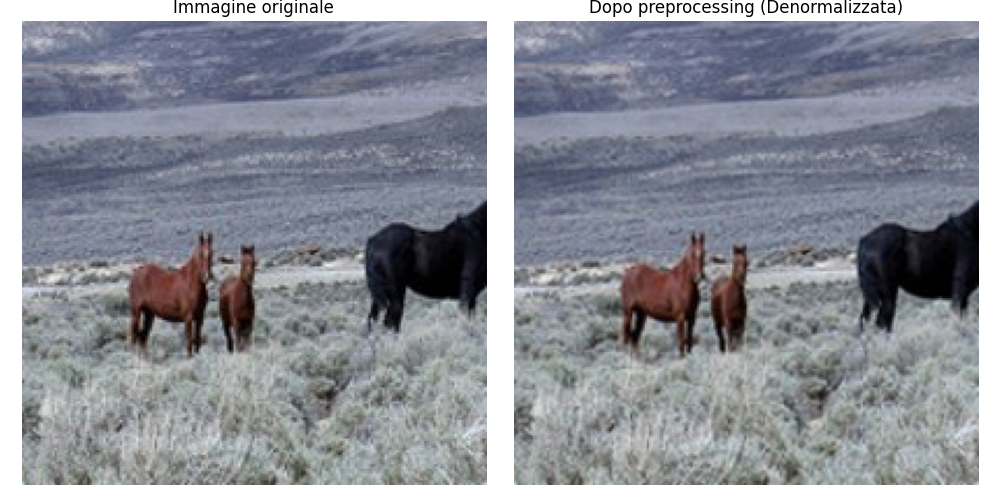


=== FASE 4: PREPARAZIONE DATI ===
Dimensioni dataset finali:
- Training: 10647 (70.0%)
- Validazione: 1520 (10.0%)
- Test: 3043 (20.0%)

=== FASE 5: ADDESTRAMENTO MODELLO ===

[FASE 1/6] Inizializzazione modelli...
[FASE 2/6] Generazione delle triplette...
[FASE 2bis/6] Generazione triplette di validazione...
[FASE 3/6] Addestramento rete Triplet...



Epoch 1/20
  Training Loss: 0.3028 | Validation Loss: 0.1882
  Delta Loss: 0.1146
Checkpoint salvato in triplet_checkpoint.pt



Epoch 2/20
  Training Loss: 0.1240 | Validation Loss: 0.1269
  Delta Loss: -0.0029
Checkpoint salvato in triplet_checkpoint.pt


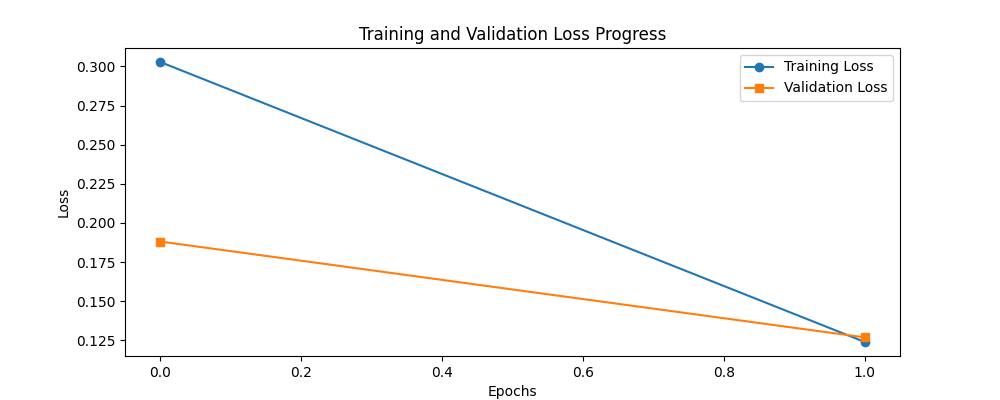


Epoch 3/20
  Training Loss: 0.0803 | Validation Loss: 0.1066
  Delta Loss: -0.0263
Checkpoint salvato in triplet_checkpoint.pt


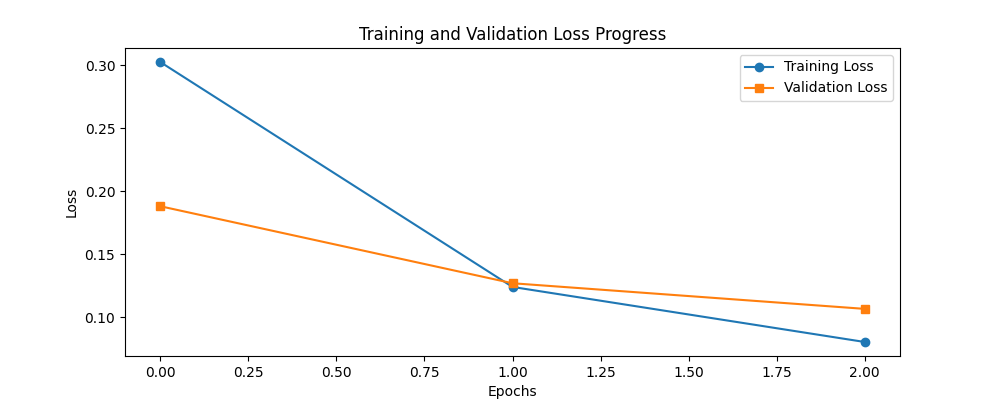


Epoch 4/20
  Training Loss: 0.0579 | Validation Loss: 0.0975
  Delta Loss: -0.0396
Checkpoint salvato in triplet_checkpoint.pt


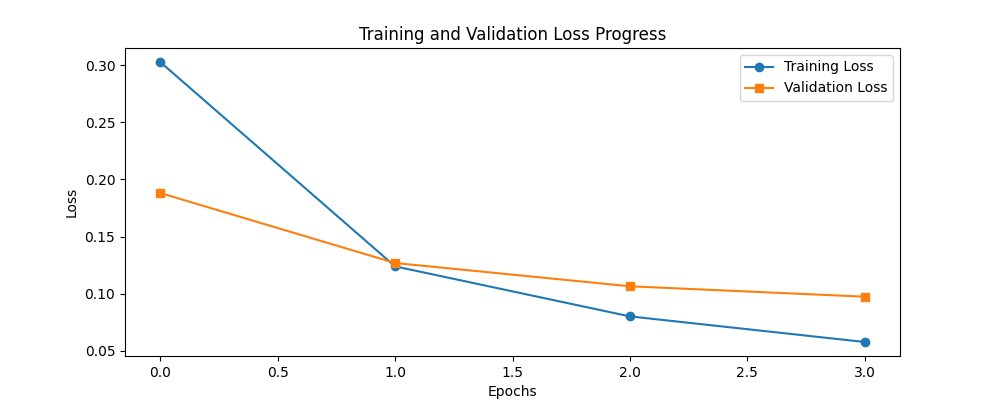


Epoch 5/20
  Training Loss: 0.0431 | Validation Loss: 0.0909
  Delta Loss: -0.0477
Checkpoint salvato in triplet_checkpoint.pt


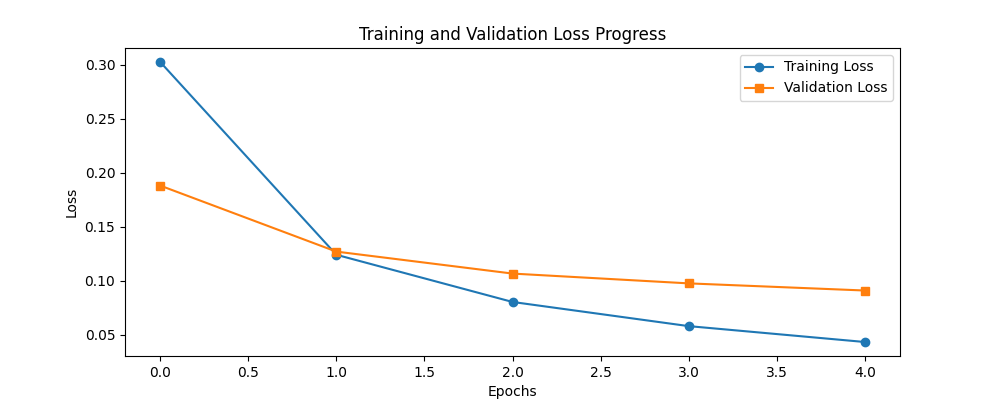


Epoch 6/20
  Training Loss: 0.0327 | Validation Loss: 0.0870
  Delta Loss: -0.0543
Checkpoint salvato in triplet_checkpoint.pt


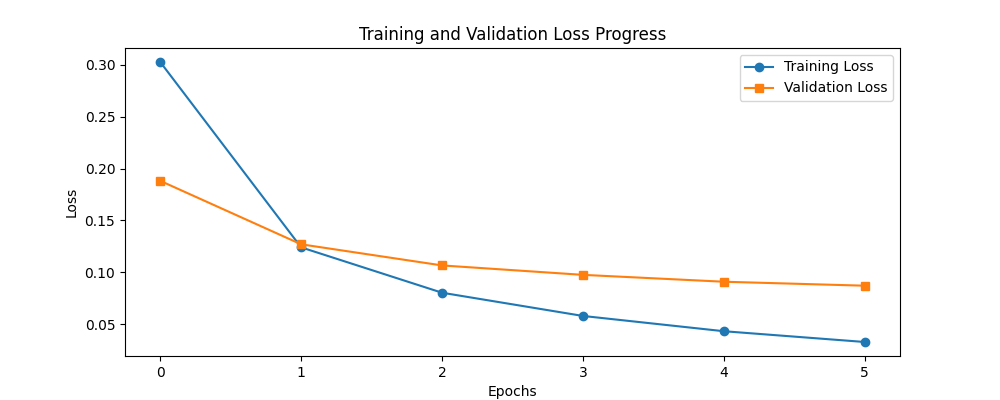


Epoch 7/20
  Training Loss: 0.0245 | Validation Loss: 0.0836
  Delta Loss: -0.0592
Checkpoint salvato in triplet_checkpoint.pt


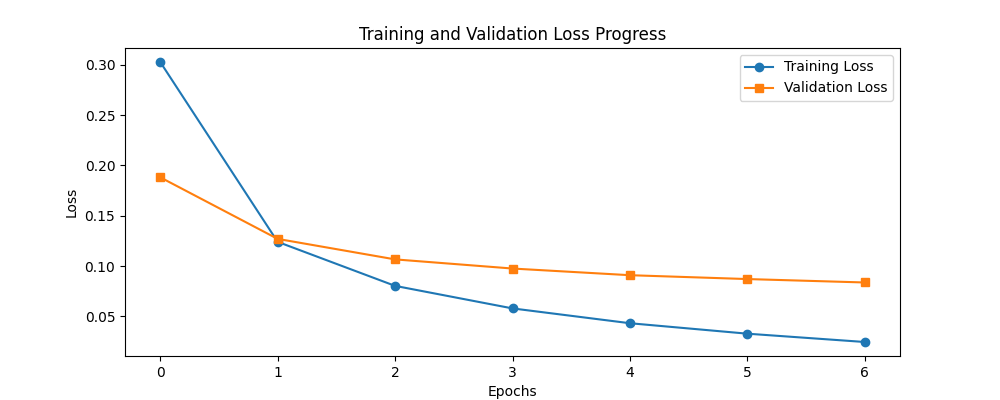


Epoch 8/20
  Training Loss: 0.0182 | Validation Loss: 0.0831
  Delta Loss: -0.0649


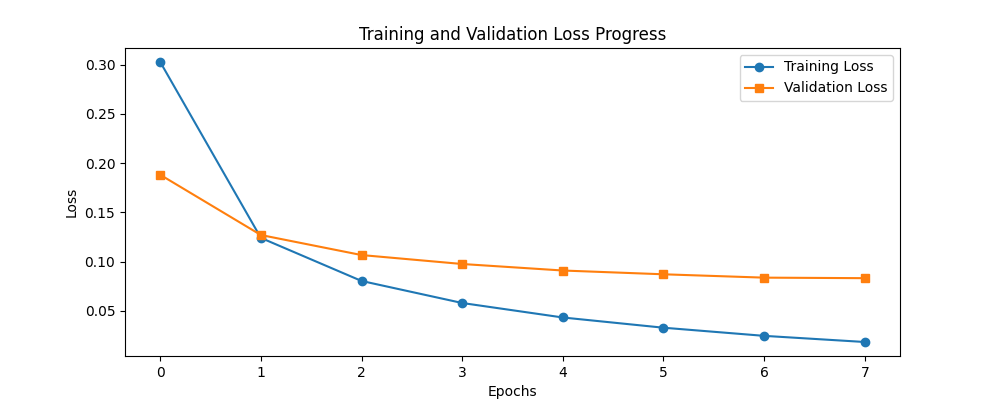


Epoch 9/20
  Training Loss: 0.0134 | Validation Loss: 0.0833
  Delta Loss: -0.0699


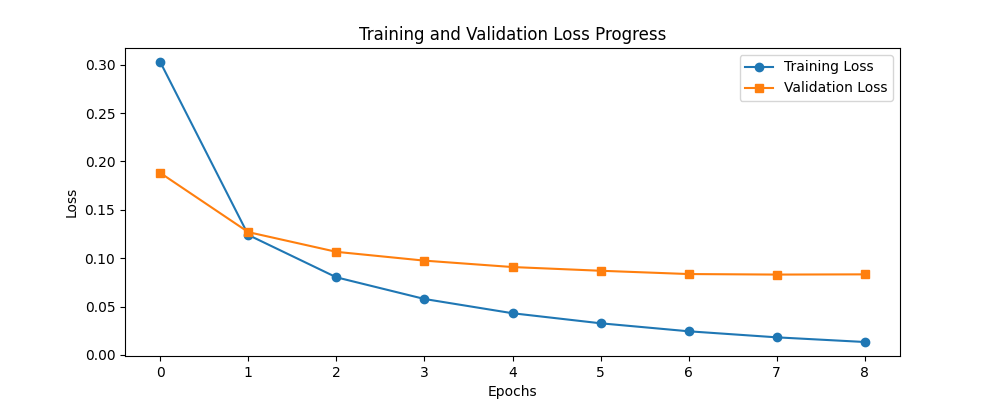


Epoch 10/20
  Training Loss: 0.0096 | Validation Loss: 0.0848
  Delta Loss: -0.0751


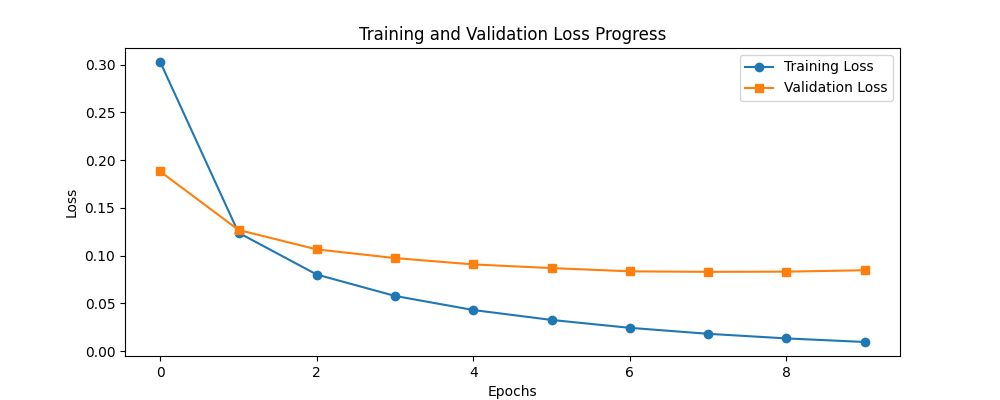


Epoch 11/20
  Training Loss: 0.0071 | Validation Loss: 0.0856
  Delta Loss: -0.0785


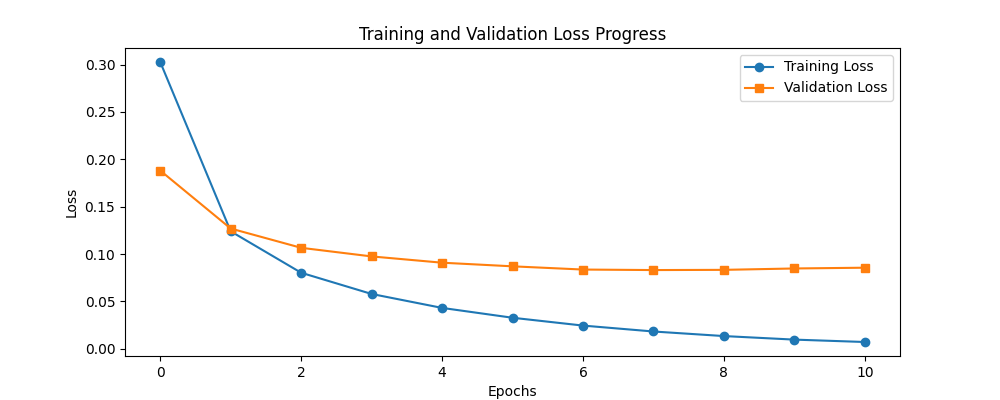


Epoch 12/20
  Training Loss: 0.0056 | Validation Loss: 0.0852
  Delta Loss: -0.0797


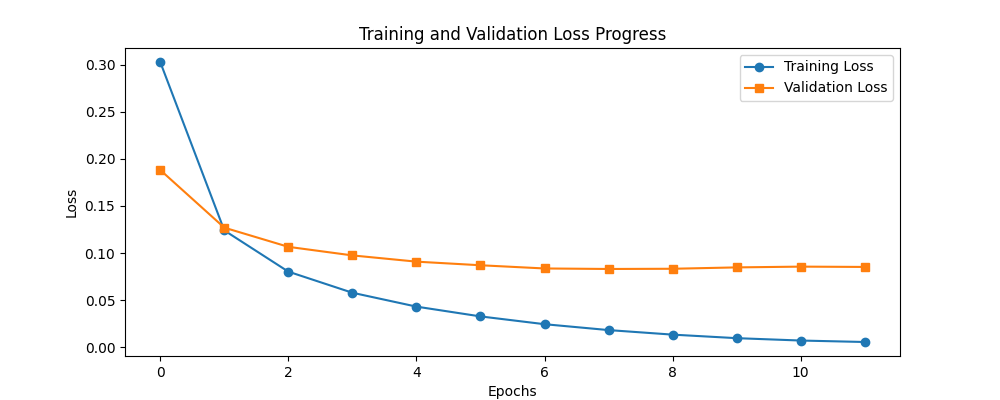

C:\Users\39327\AppData\Local\Temp\ipykernel_23660\65202784.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('triplet_checkpoint.pt')



[!] Early stopping attivato! Caricamento migliori pesi...
Checkpoint caricato correttamente

[FASE 4/6] Generazione embedding raffinati...
[FASE 5/6] Addestramento SVM...
[FASE 6/6] Valutazione finale...

[RISULTATI TRAINING SET]
--------------------------------------------------
Accuracy:  0.9532
Precision: 0.9533
Recall:    0.9532
F1-Score:  0.9532

Matrice di Confusione:
[[5047  276]
 [ 222 5102]]

Metriche per Classe:
  Classe 0 (n=5323.0):
    Precision: 0.9579
    Recall:    0.9481
    F1-Score:  0.9530
------------------------------
  Classe 1 (n=5324.0):
    Precision: 0.9487
    Recall:    0.9583
    F1-Score:  0.9535
------------------------------

[ANALISI TRAINING SET]
- Bilanciamento classi: SI (ratio: 1.00)
  - Distribuzione: ['Classe 0: 5323 (50.0%)', 'Classe 1: 5324 (50.0%)']
- Errori FP: 276, FN: 222 (ratio: 1.24)
- Simmetria errori: NO

  => SPIEGAZIONE METRICHE DIFFERENTI:
     - Le metriche differiscono perché:
        * Gli errori non sono simmetrici

[RISULTATI T

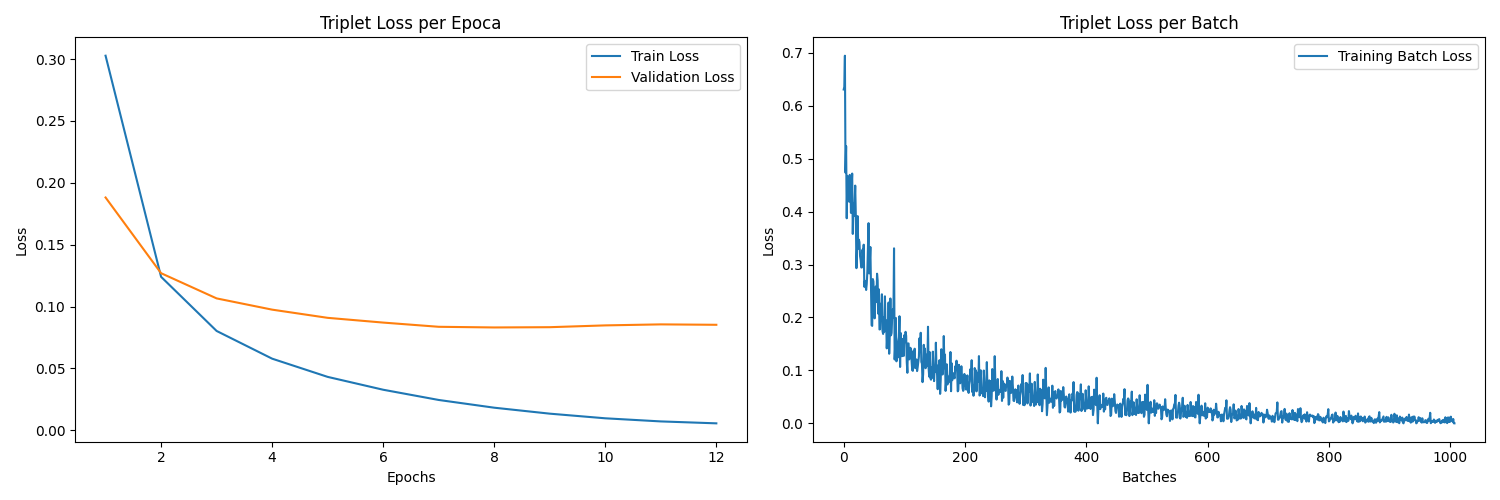

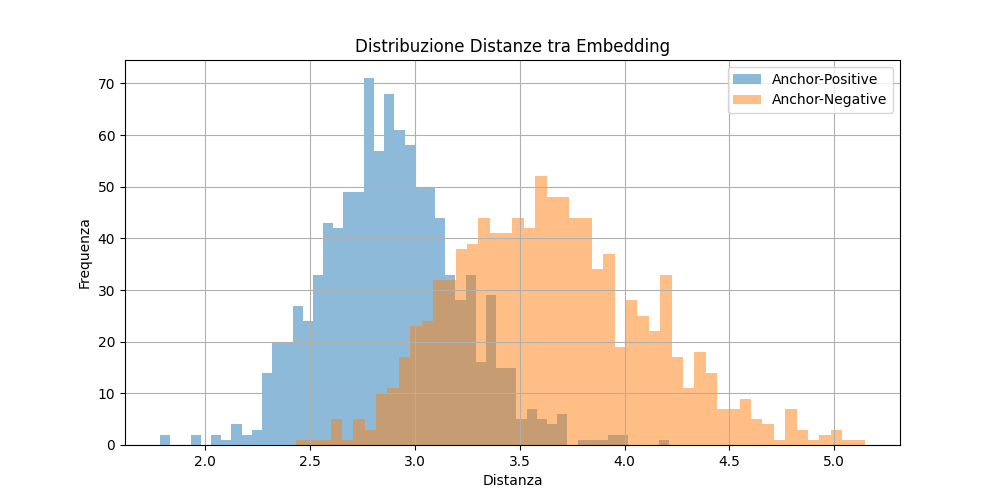


=== FASE 6: SALVATAGGIO RISULTATI ===
[SUCCESSO] Risultati salvati correttamente con backup


In [14]:
def evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test):
    # === FASE 1: INIZIALIZZAZIONE MODELLO ===
    print("\n[FASE 1/6] Inizializzazione modelli...")
    triplet_model = TripletModel().to(device)
    criterion = TripletLoss(margin=0.2)
    optimizer = optim.Adam(triplet_model.parameters(), lr=1e-4)
    early_stopping = EarlyStopping(patience=5, path='triplet_checkpoint.pt')

    # === FASE 2: PREPARAZIONE TRIPLETTE ===
    print("[FASE 2/6] Generazione delle triplette...")
    triplet_batches = generate_triplets_fixed_batch(X_train, y_train, n_triplets=len(X_train))

    # === FASE 2 BIS: GENERAZIONE TRIPLETTE DI VALIDAZIONE ===
    print("[FASE 2bis/6] Generazione triplette di validazione...")
    val_triplet_batches = generate_triplets_fixed_batch(X_val, y_val, n_triplets=len(X_val))

    # === FASE 3/6: ADDESTRAMENTO TRIPLET MODEL CON VALIDAZIONE ===
    print("[FASE 3/6] Addestramento rete Triplet...")
    train_losses = []
    val_losses = []
    batch_losses = []

    # Struttura avanzata per early stopping
    early_stopping = EarlyStopping(
        patience=5,
        verbose=True,
        delta=0.001,  # Soglia di miglioramento minimo
        path='triplet_checkpoint.pt'
    )

    for epoch in range(20):
        # === TRAINING ===
        triplet_model.train()
        epoch_train_loss = 0.0

        progress_bar = tqdm(triplet_batches, desc=f'Epoch {epoch+1}', leave=False)

        for batch in progress_bar:
            anchors, positives, negatives = batch

            # Converti i dati al dispositivo corretto
            anchors = torch.FloatTensor(anchors).to(device)
            positives = torch.FloatTensor(positives).to(device)
            negatives = torch.FloatTensor(negatives).to(device)

            # Forward pass
            optimizer.zero_grad()
            a_emb = triplet_model(anchors)
            p_emb = triplet_model(positives)
            n_emb = triplet_model(negatives)

            # Calcola loss e backpropagazione
            loss = criterion(a_emb, p_emb, n_emb)
            loss.backward()
            optimizer.step()

            # Aggiorna metriche
            epoch_train_loss += loss.item()
            batch_losses.append(loss.item())
            progress_bar.set_postfix({'train_batch_loss': loss.item()})

        # Calcola media loss training
        avg_train_loss = epoch_train_loss / len(triplet_batches)
        train_losses.append(avg_train_loss)

        # === VALIDATION ===
        triplet_model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for val_batch in val_triplet_batches:
                anchors_val, positives_val, negatives_val = val_batch

                anchors_val = torch.FloatTensor(anchors_val).to(device)
                positives_val = torch.FloatTensor(positives_val).to(device)
                negatives_val = torch.FloatTensor(negatives_val).to(device)

                # Forward pass validazione
                a_emb_val = triplet_model(anchors_val)
                p_emb_val = triplet_model(positives_val)
                n_emb_val = triplet_model(negatives_val)

                # Calcola loss validazione
                val_loss = criterion(a_emb_val, p_emb_val, n_emb_val)
                epoch_val_loss += val_loss.item()

        # Calcola media loss validazione
        avg_val_loss = epoch_val_loss / len(val_triplet_batches)
        val_losses.append(avg_val_loss)

        # === LOGGING E EARLY STOPPING ===
        print(f"\nEpoch {epoch+1}/{20}")
        print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
        print(f"  Delta Loss: {avg_train_loss - avg_val_loss:.4f}")

        # Early stopping basato su validation loss
        early_stopping(avg_val_loss, triplet_model)

        # Visualizzazione avanzata
        if epoch > 0:
            plt.figure(figsize=(10,4))
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='s')
            plt.title('Training and Validation Loss Progress')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

        if early_stopping.early_stop:
            print("\n[!] Early stopping attivato! Caricamento migliori pesi...")
            try:
                checkpoint = torch.load('triplet_checkpoint.pt')
                triplet_model.load_state_dict(checkpoint['model_state_dict'])
                print("Checkpoint caricato correttamente")
            except Exception as e:
                print(f"[ERRORE GRAVE] Impossibile caricare il checkpoint: {str(e)}")
                if Path(early_stopping.backup_path).exists():
                    print("Tentativo di caricamento backup...")
                    try:
                        checkpoint = torch.load(early_stopping.backup_path)
                        triplet_model.load_state_dict(checkpoint['model_state_dict'])
                        print("Backup caricato con successo")
                    except Exception as backup_e:
                        print(f"Errore caricamento backup: {str(backup_e)}")
                        exit()
                else:
                    print("Nessun backup disponibile. Uscita...")
                    exit()
            break  # Esci dal ciclo di training

    # === FASE 4: RIFINITURA EMBEDDING ===
    print("\n[FASE 4/6] Generazione embedding raffinati...")
    with torch.no_grad():
        X_train_refined = triplet_model(torch.FloatTensor(X_train).to(device)).cpu().numpy()
        X_test_refined = triplet_model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    # === FASE 5: CLASSIFICAZIONE SVM ===
    print("[FASE 5/6] Addestramento SVM...")
    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train_refined, y_train)

    # === FASE 6: VALUTAZIONE FINALE ===
    print("[FASE 6/6] Valutazione finale...")

    # Predizioni su training e test
    y_train_pred = svm.predict(X_train_refined)
    y_test_pred = svm.predict(X_test_refined)

    # Calcolo metriche avanzate con analisi
    def calculate_metrics(y_true, y_pred):
        # Calcola le metriche aggregate
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred)

        # Calcola le metriche per classe
        class_report = classification_report(y_true, y_pred, output_dict=True)
        per_class_metrics = {}
        for cls in np.unique(y_true):
            per_class_metrics[cls] = {
                'precision': class_report[str(cls)]['precision'],
                'recall': class_report[str(cls)]['recall'],
                'f1': class_report[str(cls)]['f1-score'],
                'support': class_report[str(cls)]['support']
            }

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'per_class': per_class_metrics
        }

    metrics = {
        'train': calculate_metrics(y_train, y_train_pred),
        'test': calculate_metrics(y_test, y_test_pred)
    }

    # Funzione di verifica per spiegare le metriche
    def verify_metrics(metrics_set, set_name):
        print(f"\n[ANALISI {set_name} SET]")
        cm = metrics_set['confusion_matrix']
        class_counts = cm.sum(axis=1)
        total_samples = np.sum(class_counts)

        # Controlla bilanciamento classi
        max_count = np.max(class_counts)
        min_count = np.min(class_counts)
        balance_ratio = min_count / max_count

        is_balanced = balance_ratio > 0.8
        print(f"- Bilanciamento classi: {'SI' if is_balanced else 'NO'} (ratio: {balance_ratio:.2f})")
        print(f"  - Distribuzione: {[f'Classe {i}: {count} ({count/total_samples:.1%})' for i, count in enumerate(class_counts)]}")

        # Controlla simmetria errori
        is_symmetric = True
        n_classes = len(cm)
        if n_classes == 2:  # Caso binario
            fp = cm[0, 1]
            fn = cm[1, 0]
            error_ratio = fp / fn if fn != 0 else 1.0
            print(f"- Errori FP: {fp}, FN: {fn} (ratio: {error_ratio:.2f})")
            is_symmetric = 0.8 <= error_ratio <= 1.2
        else:  # Caso multiclasse
            for i in range(n_classes):
                for j in range(n_classes):
                    if i != j and cm[i, j] > 0:
                        reverse_error = cm[j, i]
                        if reverse_error == 0:
                            is_symmetric = False
                        else:
                            ratio = cm[i, j] / reverse_error
                            if not (0.8 <= ratio <= 1.2):
                                is_symmetric = False

        print(f"- Simmetria errori: {'SI' if is_symmetric else 'NO'}")

        # Spiegazione risultati
        if metrics_set['accuracy'] == metrics_set['precision'] == metrics_set['recall'] == metrics_set['f1']:
            print("\n  => SPIEGAZIONE METRICHE UGUALI:")
            if is_balanced and is_symmetric:
                print("     - Le metriche coincidono perché:")
                print("        * Le classi sono bilanciate")
                print("        * Gli errori sono distribuiti simmetricamente")
            else:
                print("     - Coincidenza casuale dovuta a:")
                if not is_balanced:
                    print("        * Sbilanciamento classi")
                if not is_symmetric:
                    print("        * Errori asimmetrici")
        else:
            print("\n  => SPIEGAZIONE METRICHE DIFFERENTI:")
            print("     - Le metriche differiscono perché:")
            if not is_balanced:
                print("        * Le classi non sono bilanciate")
            if not is_symmetric:
                print("        * Gli errori non sono simmetrici")

    # Visualizzazione avanzata dei risultati
    def print_metrics(metrics_set, set_name):
        print(f"\n{'='*50}")
        print(f"[RISULTATI {set_name} SET]")
        print('-'*50)
        print(f"Accuracy:  {metrics_set['accuracy']:.4f}")
        print(f"Precision: {metrics_set['precision']:.4f}")
        print(f"Recall:    {metrics_set['recall']:.4f}")
        print(f"F1-Score:  {metrics_set['f1']:.4f}")

        print("\nMatrice di Confusione:")
        print(metrics_set['confusion_matrix'])

        print("\nMetriche per Classe:")
        for cls, cls_metrics in metrics_set['per_class'].items():
            print(f"  Classe {cls} (n={cls_metrics['support']}):")
            print(f"    Precision: {cls_metrics['precision']:.4f}")
            print(f"    Recall:    {cls_metrics['recall']:.4f}")
            print(f"    F1-Score:  {cls_metrics['f1']:.4f}")
            print('-'*30)

    # Stampa risultati e analisi
    print_metrics(metrics['train'], "TRAINING")
    verify_metrics(metrics['train'], "TRAINING")

    print_metrics(metrics['test'], "TEST")
    verify_metrics(metrics['test'], "TEST")

    # Plot metriche
    plot_losses(train_losses, val_losses, batch_losses, len(train_losses))
    plot_distance_distribution(triplet_batches, triplet_model)

    # Pulizia memoria
    clean_memory()

    return {
        'triplet_model': triplet_model,
        'svm': svm,
        'metrics': metrics,
        'embeddings': (X_train_refined, X_test_refined)
    }

if __name__ == "__main__":
    # === FASE 1: SETUP INIZIALE ===
    print("\n=== FASE 1: CONFIGURAZIONE INIZIALE ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Dispositivo selezionato: {device}")

    model, preprocess = clip.load("ViT-B/32", device=device)

    # Importa Path e definisci BASE_DATASET_PATH
    from pathlib import Path
    BASE_DATASET_PATH = Path("..") / "dataset" / "cycle_gan"
    BASE_DATASET_PATH = BASE_DATASET_PATH.resolve()
    print(f"[INFO] Percorso base del dataset: {BASE_DATASET_PATH}")

    # === FASE 2: CARICAMENTO CYCLE_GAN ===
    print("\n=== FASE 2: CARICAMENTO CYCLE_GAN ===")
    try:
        dataset_cycle_gan = get_datasets(metadata_list, index=5)
        # Correzione sintassi list comprehension
        image_paths = [str((BASE_DATASET_PATH / row['image_path']).resolve())
                       for _, row in dataset_cycle_gan.iterrows()]
        print(f"[SUCCESSO] Caricati {len(image_paths)} immagini")
    except Exception as e:
        print(f"[ERRORE CRITICO] Caricamento dataset fallito: {str(e)}")
        exit()


    # === FASE 3: ESTRAZIONE EMBEDDING ===
    print("\n=== FASE 3: ESTRAZIONE EMBEDDING CLIP ===")
    try:
        embeddings, labels = generate_and_save_embeddings(image_paths, model)
        print(f"[SUCCESSO] Generati {len(embeddings)} embedding")

        # Creazione dizionario per verifica
        embeddings_dict = {}
        for i, img_path in enumerate(image_paths):
            filename = Path(img_path).name
            embeddings_dict[filename] = {
                'image_path': img_path,
                'target': labels[i],
                'embedding': embeddings[i]
            }

        # === FASE 3bis: VERIFICA EMBEDDING ===
        print("\n=== FASE 3bis: VERIFICA EMBEDDING ===")
        verifica_embedding_clip(
            model=model,
            preprocess=preprocess,
            embeddings_dict=embeddings_dict,
            dataset_df=dataset_cycle_gan,
            index=0  # Verifica la prima immagine
        )

    except Exception as e:
        print(f"[ERRORE] Estrazione embedding fallita: {str(e)}")
        exit()

    # === FASE 4: PREPARAZIONE DATI ===
    print("\n=== FASE 4: PREPARAZIONE DATI ===")
    try:
        # Split 70-30
        X_train, X_temp, y_train, y_temp = train_test_split(
            embeddings,
            labels,
            test_size=0.3,
            stratify=labels,
            random_state=42
        )

        # Split 10-20
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp,
            y_temp,
            test_size=0.6667,
            stratify=y_temp,
            random_state=42
        )

        print("Dimensioni dataset finali:")
        print(f"- Training: {len(X_train)} ({len(X_train)/len(embeddings):.1%})")
        print(f"- Validazione: {len(X_val)} ({len(X_val)/len(embeddings):.1%})")
        print(f"- Test: {len(X_test)} ({len(X_test)/len(embeddings):.1%})")

    except Exception as e:
        print(f"[ERRORE] Preparazione dati fallita: {str(e)}")
        exit()

    # === FASE 5: ADDESTRAMENTO E VALUTAZIONE ===
    print("\n=== FASE 5: ADDESTRAMENTO MODELLO ===")
    try:
        results = evaluate_model(
            X_train=X_train,
            X_val=X_val,
            X_test=X_test,
            y_train=y_train,
            y_val=y_val,
            y_test=y_test
        )
    except Exception as e:
        print(f"[ERRORE GRAVE] Addestramento fallito: {str(e)}")
        exit()

    # === FASE 6: SALVATAGGIO SICURO RISULTATI ===
    print("\n=== FASE 6: SALVATAGGIO RISULTATI ===")
    try:
        # VERIFICA SPAZIO SU DISCO (MODIFICATO PER WINDOWS)
        import psutil  # Aggiungi questa dipendenza
        usage = psutil.disk_usage(str(Path.cwd()))
        free_space = usage.free

        if free_space < 1e9:
            raise IOError("Spazio su disco insufficiente (<1GB)")

        # SALVATAGGIO PRINCIPALE
        with open('cycle_gan_results.pkl', 'wb') as f:
            pickle.dump(results, f)

        # CREA BACKUP
        copyfile('cycle_gan_results.pkl', 'cycle_gan_results_backup.pkl')

        # VERIFICA INTEGRITÀ FILE
        with open('cycle_gan_results.pkl', 'rb') as f:
            pickle.load(f)

        print("[SUCCESSO] Risultati salvati correttamente con backup")

    except Exception as e:
        print(f"[ERRORE] Salvataggio risultati fallito: {str(e)}")
        if Path('cycle_gan_results_backup.pkl').exists():
            print("[WARNING] Utilizzo backup risultati precedenti")
            copyfile('cycle_gan_results_backup.pkl', 'cycle_gan_results.pkl')
        exit()